In [57]:
import os
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F

#from skimage import io
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix
from sklearn import metrics, preprocessing
import timm
import albumentations as A
import albumentations.pytorch
import wandb

##### Parameters

In [58]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 200,
    'train_bs':128,
    'valid_bs':64,
    'lr': 1e-4,
    'num_workers': 10,
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 6,
    'model_path': './models'
}

#### Train Valid Test dataset
##### Natural data (coco) train: 10000 // valid: 2900 // test: 1500
##### Generated data (coco captions) train: 10000 (Augneted 3000, generated 7000) // valid: 2900 // test: 1500

In [59]:
folder_path = './data/generated_images/train'
files = os.listdir(folder_path)
print(len(files))
#files

7001


In [60]:
# Initialize the data structure
data = {
    'id': [],
    'path': [],
    'label': [],
    'type': []  # Distinguishing between train, valid, and test
}

# Define the base directory
base_dir = './data'

# Define the subdirectories and labels
categories = {
    'generated_images': 'generated',
    'natural_images': 'natural'
}

# Include 'test' in the subfolders
subfolders = ['train', 'valid', 'test']

# Function to process each directory
def process_directory(path, label, folder_type):
    for root, dirs, files in os.walk(path):
        # Only proceed if in the right subfolder
        if os.path.basename(root) in subfolders:
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust for image formats as necessary
                    data['id'].append(file)
                    data['path'].append(os.path.join(root, file))
                    data['label'].append(label)
                    data['type'].append(folder_type)

# Iterate through each category and its specified subdirectories
for category, label in categories.items():
    for subfolder in subfolders:
        dir_path = os.path.join(base_dir, category, subfolder)
        process_directory(dir_path, label, subfolder)

# Convert the entire data to a DataFrame
df = pd.DataFrame(data)
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['label'].values)

# Creating separate dataframes for train, valid, and test
df_train = df[df['type'] == 'train'].reset_index(drop=True)
df_valid = df[df['type'] == 'valid'].reset_index(drop=True)
df_test = df[df['type'] == 'test'].reset_index(drop=True)

In [61]:
df_valid


,id,path,label,type
0,folder2_05076.png,./data/generated_images/valid/folder2_05076.png,0,valid
1,folder2_02580.png,./data/generated_images/valid/folder2_02580.png,0,valid
2,folder1_01296.png,./data/generated_images/valid/folder1_01296.png,0,valid
3,folder1_04224.png,./data/generated_images/valid/folder1_04224.png,0,valid
4,folder2_02295.png,./data/generated_images/valid/folder2_02295.png,0,valid
...,...,...,...,...
5795,000000421602.jpg,./data/natural_images/valid/000000421602.jpg,1,valid
5796,000000183435.jpg,./data/natural_images/valid/000000183435.jpg,1,valid
5797,000000133436.jpg,./data/natural_images/valid/000000133436.jpg,1,valid
5798,000000447520.jpg,./data/natural_images/valid/000000447520.jpg,1,valid


In [62]:
df_train

,id,path,label,type
0,folder2_03497.png,./data/generated_images/train/folder2_03497.png,0,train
1,folder2_02183.png,./data/generated_images/train/folder2_02183.png,0,train
2,folder1_06745.png,./data/generated_images/train/folder1_06745.png,0,train
3,folder1_05603.png,./data/generated_images/train/folder1_05603.png,0,train
4,folder2_02777.png,./data/generated_images/train/folder2_02777.png,0,train
...,...,...,...,...
16995,000000326064.jpg,./data/natural_images/train/000000326064.jpg,1,train
16996,000000205000.jpg,./data/natural_images/train/000000205000.jpg,1,train
16997,000000219739.jpg,./data/natural_images/train/000000219739.jpg,1,train
16998,000000462164.jpg,./data/natural_images/train/000000462164.jpg,1,train


#### Wandb (Trainning log tracking) init, project name define 

In [63]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'gen_'+ 'icp_res'
user = 'hojunking'
run_name = project_name + '_' + run_id

In [64]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

##### All images have been augmented physically, only transform the images to be resized by 256 by 256

In [65]:
transform = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.transforms.ToTensorV2()
    ])

#### Dataset

In [66]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.output_label = output_label
        
        if output_label:
            self.labels = self.df['label'].values
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # Constructing the image path directly from the DataFrame
        img_path = self.df.loc[index, 'path']
        im_bgr = cv2.imread(img_path)
        
        # Check if image is loaded successfully
        if im_bgr is not None:
            img = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        else:
            # If the image is not successfully loaded, create a black image of the defined size
            img = np.zeros([CFG['img_size'], CFG['img_size'], 3], dtype=np.uint8)

        # Crop the image from the center
        min_side = min(img.shape[:2])
        center_crop = A.Compose([
            A.CenterCrop(height=min_side, width=min_side),  # Crop the center to the target size
        ])
        cropped_image = center_crop(image=img)["image"]

        # Apply transformations
        if self.transform:
            transformed_img = self.transform(image=cropped_image)['image']
        else:
            transformed_img = cropped_image
        
        # Get labels
        if self.output_label:
            target = self.labels[index]
            return transformed_img, target
        else:
            return transformed_img


#### Model Define

In [67]:
class baseModel(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        # n_features = self.model.classifier.in_features
        # self.model.classifier = nn.Linear(n_features, n_class)
    
    def freezing(self, freeze=False, trainable_layer=2):
        if freeze:
            # Freeze all parameters first
            for param in self.model.parameters():
                param.requires_grad = False

            # Unfreeze the last few layers
            if hasattr(self.model, 'features'):  # for models with 'features' block
                for param in self.model.features[-trainable_layer:].parameters():
                    param.requires_grad = True

            if hasattr(self.model, 'classifier'):  # for models with 'classifier' block
                for param in self.model.classifier.parameters():
                    param.requires_grad = True 
            
    def forward(self, x):
        x = self.model(x)
        return x

##### Define Dataloader

In [68]:
def prepare_dataloader(df_train, df_valid):
    
    train_ds = CustomDataset(df_train, transform=transform, output_label=True)
    valid_ds = CustomDataset(df_valid, transform=transform,  output_label=True)

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,
        num_workers=CFG['num_workers'],
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

#### Train

In [69]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    model.train()  # Set model to training mode

    running_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs, image_labels = imgs.to(device).float(), image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)  # forward pass
            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()  # backward pass with scaled loss
            scaler.step(optimizer)
            scaler.update()

        running_loss = 0.99 * running_loss + 0.01 * loss.item()  # update running loss
        
        # Update pbar description
        pbar.set_description(f'Epoch {epoch} Loss: {running_loss:.4f}')
        
        image_preds_all.append(torch.argmax(image_preds, 1).detach().cpu().numpy())
        image_targets_all.append(image_labels.detach().cpu().numpy())
        
    if scheduler is not None:
        scheduler.step()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    accuracy = np.mean(image_preds_all == image_targets_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    return image_preds_all, accuracy, running_loss / len(train_loader), confusion_matrix(image_targets_all, image_preds_all), epoch_f1


##### Valid

In [70]:
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()  # Set model to evaluation mode

    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    with torch.no_grad():  # No gradients needed for validation
        for step, (imgs, image_labels) in pbar:
            imgs, image_labels = imgs.to(device).float(), image_labels.to(device).long()
            
            image_preds = model(imgs)  # forward pass
            loss = loss_fn(image_preds, image_labels)  # calculate loss

            # Aggregate predictions and targets for metrics calculation
            image_preds_all.append(torch.argmax(image_preds, 1).detach().cpu().numpy())
            image_targets_all.append(image_labels.detach().cpu().numpy())

            loss_sum += loss.item() * image_labels.shape[0]  # total loss for average calculation
            
            # Update pbar description
            pbar.set_description(f'Epoch {epoch} Loss: {loss_sum/((step+1) * val_loader.batch_size):.4f}')
    
    # Convert list of arrays to single numpy array for metric calculation
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    # Calculate performance metrics
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = np.mean(image_preds_all == image_targets_all)
    val_loss = loss_sum / len(image_targets_all)  # average loss

    # Step the scheduler if it's based on validation loss and such option is enabled
    if scheduler is not None and schd_loss_update:
        scheduler.step(val_loss)

    return image_preds_all, acc, val_loss, confusion_matrix(image_targets_all, image_preds_all), epoch_f1


##### Define EarlyStopping

In [71]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf  # Initialize this to a large number
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss  # Convert to a score (as lower loss is better, we negate it)

        if self.verbose:
            print(f'Validation loss: {val_loss}')

        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                print(f'Best validation loss: {self.val_loss_min}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss  # Update the minimum validation loss
            self.counter = 0  # Reset counter

        return self.early_stop


In [72]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # EARLY STOPPING DEFINITION
    early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

    # DATALOADER DEFINITION
    train_loader, val_loader = prepare_dataloader(df_train, df_valid)

    # MODEL & DEVICE DEFINITION 
    device = torch.device(CFG['device'])
    model =baseModel(CFG['model'], df_train.label.nunique(), pretrained=True)
    
    # MODEL FREEZING
    #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
    if CFG['freezing'] ==True:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print(f"{name}: {param.requires_grad}")

    model.to(device)
    # MODEL DATA PARALLEL
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    scaler = torch.cuda.amp.GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

    # CRITERION (LOSS FUNCTION)
    loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)

    wandb.watch(model, loss_tr, log='all')
    train_acc_list = []
    train_matrix_list = []
    train_f1_list = []
    valid_acc_list = []
    valid_matrix_list = []
    valid_f1_list = []
    

    start = time.time()
    for epoch in range(CFG['epochs']):
        print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

        # TRAINIG
        train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                    optimizer, train_loader, device, scheduler=scheduler)
        wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

        # VALIDATION
        with torch.no_grad():
            valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                    val_loader, device, scheduler=None)
            wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
        print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
        
        # SAVE ALL RESULTS
        train_acc_list.append(train_acc)
        train_matrix_list.append(train_matrix)
        train_f1_list.append(train_f1)

        valid_acc_list.append(valid_acc)
        valid_matrix_list.append(valid_matrix)
        valid_f1_list.append(valid_f1)

        # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
        if valid_f1 > best_f1:
            best_f1 = valid_f1
            best_epoch = epoch
            # SAVE WITH DATAPARARELLEL WRAPPER
            #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
            # SAVE WITHOUT DATAPARARELLEL WRAPPER
            torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

        # EARLY STOPPING
        stop = early_stopping(valid_f1)
        if stop:
            print("stop called")   
            break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Accuracy,▁▇███████
Train F1,▁▇███████
Train Loss,█▂▂▁▁▁▁▁▁
Valid Accuracy,▅▆▅▁▇▇█▇▆
Valid F1,▅▆▅▁▇▇█▇▆
Valid Loss,▂▂▂█▂▁▁▁▃
epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
Train Accuracy,0.99953
Train F1,0.99951
Train Loss,1e-05
Valid Accuracy,0.97672


Model: resnet50


model.safetensors: 100%|██████████| 102M/102M [00:10<00:00, 9.91MB/s] 

Epoch 0/199



Epoch 0 Loss: 0.2280: 100%|██████████| 91/91 [00:40<00:00,  2.27it/s]


Epoch [0], Train Loss : [0.00228] Val Loss : [0.22894] Val F1 Score : [0.94551]
Validation loss: 0.9455083711010746
time : 0:02:27
Best Train Marco F1 : 0.71465
[[3160 3840]
 [ 291 9709]]
Best Valid Marco F1 : 0.94551
[[2705  195]
 [ 121 2779]]
Epoch 1/199


Epoch 1 Loss: 0.1087: 100%|██████████| 91/91 [00:39<00:00,  2.30it/s]


Epoch [1], Train Loss : [0.00063] Val Loss : [0.10916] Val F1 Score : [0.95858]
Validation loss: 0.95857529487724
EarlyStopping counter: 1 out of 5
Best validation loss: 0.9455083711010746
time : 0:04:53
Best Train Marco F1 : 0.95889
[[6690  310]
 [ 368 9632]]
Best Valid Marco F1 : 0.95858
[[2876   24]
 [ 216 2684]]
Epoch 2/199


Epoch 2 Loss: 0.0666:  62%|██████▏   | 56/91 [00:32<00:06,  5.16it/s]

#### Test

In [47]:
df_test

,id,path,label,type
0,folder1_01804.png,./data/generated_images/test/folder1_01804.png,0,test
1,folder1_01315.png,./data/generated_images/test/folder1_01315.png,0,test
2,folder1_03599.png,./data/generated_images/test/folder1_03599.png,0,test
3,folder2_03260.png,./data/generated_images/test/folder2_03260.png,0,test
4,folder1_02035.png,./data/generated_images/test/folder1_02035.png,0,test
...,...,...,...,...
2995,000000531423.jpg,./data/natural_images/test/000000531423.jpg,1,test
2996,000000204775.jpg,./data/natural_images/test/000000204775.jpg,1,test
2997,000000412690.jpg,./data/natural_images/test/000000412690.jpg,1,test
2998,000000545375.jpg,./data/natural_images/test/000000545375.jpg,1,test


In [48]:
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []

    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc="Inference Batches")
    with torch.no_grad():  # No gradients needed for inference
        for step, imgs in pbar:
            imgs = imgs.to(device).float()

            # Forward pass
            image_preds = model(imgs)
            # Apply softmax to calculate probabilities
            image_preds_all.append(torch.softmax(image_preds, 1).detach().cpu().numpy())
    
    # Concatenate all batch predictions
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all


##### Test

In [49]:
# Initialize the model with the right architecture and number of classes
model = baseModel(CFG['model'], df_test.label.nunique(), pretrained=True)

# Load the trained weights into the model
load_model_path = CFG['model_path'] + '/gen_icp_res_202312262110/' + CFG['model'] + '.pth'
model.load_state_dict(torch.load(load_model_path, map_location=device))

# Prepare the test dataset and loader
tst_ds = CustomDataset(df_test, transform=transform, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Wrap the model with DataParallel if using multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Run inference and collect predictions
with torch.no_grad():
    predictions = inference(model, tst_loader, device)

# Assuming the task is a classification, convert softmax outputs to predicted class labels
df_test['pred'] = np.argmax(predictions, axis=1)

## Decode labels & Predictions
df_test['label'] = le.inverse_transform(df_test['label'].values)
df_test['pred'] = le.inverse_transform(df_test['pred'].values)
df_test


Inference Batches: 100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


,id,path,label,type,pred
0,folder1_01804.png,./data/generated_images/test/folder1_01804.png,generated,test,generated
1,folder1_01315.png,./data/generated_images/test/folder1_01315.png,generated,test,generated
2,folder1_03599.png,./data/generated_images/test/folder1_03599.png,generated,test,generated
3,folder2_03260.png,./data/generated_images/test/folder2_03260.png,generated,test,generated
4,folder1_02035.png,./data/generated_images/test/folder1_02035.png,generated,test,generated
...,...,...,...,...,...
2995,000000531423.jpg,./data/natural_images/test/000000531423.jpg,natural,test,natural
2996,000000204775.jpg,./data/natural_images/test/000000204775.jpg,natural,test,natural
2997,000000412690.jpg,./data/natural_images/test/000000412690.jpg,natural,test,generated
2998,000000545375.jpg,./data/natural_images/test/000000545375.jpg,natural,test,generated


accuracy: 0.9790
f1_score: 0.9790


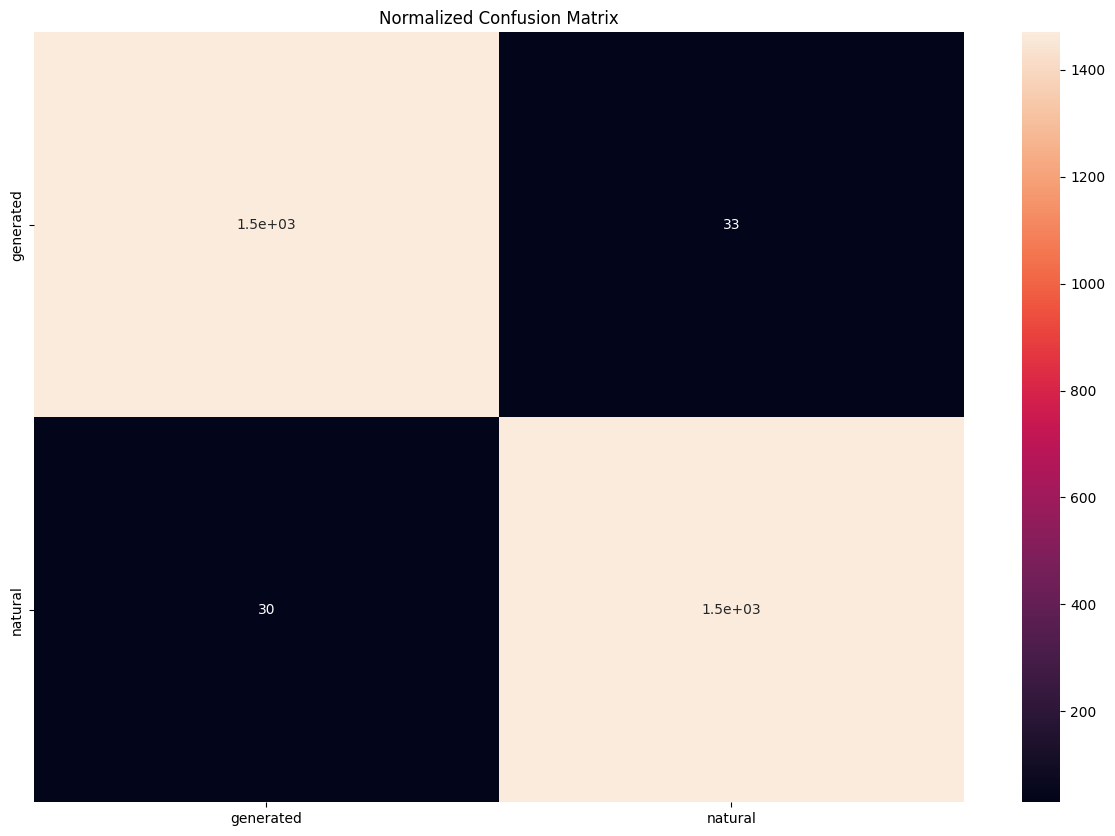

In [53]:
import seaborn as sns

test_acc = np.sum(df_test.label == df_test.pred) / len(df_test)
test_matrix = confusion_matrix(df_test['label'], df_test['pred'])
epoch_f1 = f1_score(df_test['label'], df_test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

#test_matrix = confusion_matrix(df_test['label'], df_test['pred'], normalize='true')
test_matrix = confusion_matrix(df_test['label'], df_test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(df_test['label'])), 
            yticklabels = sorted(set(df_test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [56]:
from sklearn.metrics import confusion_matrix

# Assuming df_test['true'] contains the true labels and df_test['pred'] contains the predicted labels
true_labels = df_test['label'].values  # or however you have your true labels stored
predicted_labels = df_test['pred'].values

# Get confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Find indices of TN and FP
TN_indices = np.where((predicted_labels == 0) & (true_labels == 0))[0]
FP_indices = np.where((predicted_labels == 1) & (true_labels == 0))[0]

# Select 5 random samples from each
np.random.seed(42)  # for reproducibility
sample_TN = np.random.choice(TN_indices, 5, replace=False)
sample_FP = np.random.choice(FP_indices, 5, replace=False)


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
def load_images(indices, df):
    images = []
    for idx in indices:
        img_path = df.loc[idx, 'path']  # Assuming 'path' column has the image paths
        img = Image.open(img_path)
        images.append(img)
    return images

# Load images
TN_images = load_images(sample_TN, df_test)
FP_images = load_images(sample_FP, df_test)


In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, title):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

# Plotting the results
plot_images(TN_images, "True Negative")
plot_images(FP_images, "False Positive")
